<a href="https://colab.research.google.com/github/blancavazquez/diplomado_IA/blob/main/notebooks/Tema_03/ResNet_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulo 11: Introducción a las redes neuronales
## Tema 3: Redes convolucionales


El objetivo de esta libreta es construir una red convolucional para clasificación multiclase. En esta libreta aprenderemos:

* Aumentado de datos con pytorch
* Uso de la clase dataloader en pytorch
* Cargar los pesos de modelos pre-entrenados.


En esta libreta, se usarán imágenes de la base de datos de: [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html)

#### Instalación de bibliotecas necesarias.

In [1]:
#Montaje de drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pycm==4.0
!pip install torchvision
!pip install torch
!pip install pretrainedmodels
!pip install torchcam

In [3]:
#Carga de bibliotecas
import os
import time
import torch
import warnings
import torchvision
import numpy as np
import torch.nn as nn
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pycm import ConfusionMatrix
from skimage.color import rgb2gray
from torch.optim import lr_scheduler
from torchvision.transforms import v2
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [4]:
"""************** Configuración de hiperparámetros ***********"""
lr = 0.001
epochs = 5 #1
classes = 3
patience = 10
batch_size = 32 #16
momentum = 0.9
image_resize = 256 #128
retrained_model = "resnet18"
filename = "resnet18"
path = "/content/drive/MyDrive/Colab Notebooks/2024_DiplomadoIA/Data/bd_dogs/"
criterion = nn.CrossEntropyLoss()
clases=['Collie','Labrador_retriever','Shih_Tzu']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cpu


In [5]:
def imshow(inp, title=None):
    """Función para visualizar imágenes"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

## Paso 1: Preprocesamiento de datos

In [6]:
def preprocessing(path):
    print("\n\n ****** Pre-processing data ******")
    train_transform = v2.Compose([v2.RandomResizedCrop((image_resize,image_resize),antialias=True), #224, 224
                                  v2.RandomHorizontalFlip(p=0.5),
                                  v2.Grayscale(),
                                  v2.ToTensor(),
                                  v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    val_transform = v2.Compose([v2.Resize((image_resize,image_resize)),
                                v2.CenterCrop(image_resize),
                                v2.Grayscale(),
                                v2.ToTensor(),
                                v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    test_transform = v2.Compose([v2.Resize((image_resize,image_resize)),
                                v2.ToTensor(),
                                v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    print("\n*Loading data")
    train_dataset = datasets.ImageFolder(root=path+"train/",transform=train_transform)
    val_dataset = datasets.ImageFolder(root=path+"val/",transform=val_transform)
    test_dataset = datasets.ImageFolder(root=path+"test/",transform=test_transform)
    print("Size train_dataset: ", len(train_dataset))
    print("Size val_dataset: ", len(val_dataset))
    print("Size test_dataset: ", len(test_dataset))

    print("\n*Loading dataloaders")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader,test_loader, len(train_dataset), len(val_dataset)

In [7]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def save_model(epochs, model, optimizer, criterion):
    """
    function for saving model
    """
    #Guardar el mejor modelo
    if not os.path.exists('modelos'):
      os.mkdir('modelos')

    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'modelos/cnn.pth')

def plotting_loss(train_acc, valid_acc, train_loss, valid_loss, filename):
    """
    Function for plotting performance during the training
    """
    # accuracy plots
    fig = plt.figure(figsize=(12,7)) #x,y
    plt.subplots_adjust(wspace=0.3,hspace=0.4)

    #Plotting: Accuracy
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(train_loss, label ="Train", color = "red")
    ax1.plot(valid_loss, label ="Val", color = "blue")
    ax1.grid(True, linestyle='-', linewidth=0.4)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training loss',fontsize=10)

    #Plotting: Loss
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(train_acc, label ="Train", color = "red")
    ax2.plot(valid_acc, label ="Val", color = "blue")
    ax2.grid(True, linestyle='-', linewidth=0.4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy %')
    ax2.set_ylim(0,1)
    ax2.legend()
    ax2.set_title('Overall accuracy',fontsize=10)

def compute_metrics(y_true, y_pred):
    cm = ConfusionMatrix(y_true, y_pred, digit=2)
    print(cm)
    Accuracy_overall = cm.overall_stat['F1 Macro']
    f1 = cm.overall_stat['Overall ACC']
    cm.plot(cmap=plt.cm.Reds, number_label=True, plot_lib="seaborn") #normalized=True
    print(f"F1 score: {f1:.3f}")
    print("Accuracy_overall: ", np.round(Accuracy_overall* 100,2), "%")

def train(model, trainloader, optimizer, scheduler,criterion, device, num_images_train):
    """
    Función para entrenar el clasificador multiclase
    """
    model.train()
    acc = 0
    counter = 0

    running_loss = 0.0
    running_corrects = 0

    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        prediction = model(image) # forward pass
        _, preds = torch.max(prediction, 1)
        loss = criterion(prediction, labels)
        loss.backward() # backpropagation
        optimizer.step() # update the optimizer parameters
        running_loss += loss.item() * image.size(0)
        running_corrects += torch.sum(preds == labels.data) #Cuenta el número de imágenes predichas correctamente
        scheduler.step()
    epoch_loss = running_loss / num_images_train
    epoch_acc = running_corrects / num_images_train
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion, device, num_images_val):
    """
    Función para validar el clasificador multiclase
    """
    model.eval()
    val_accuracy = 0
    counter = 0
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, labels = data
            labels = labels.to(device)
            image = image.to(device)
            outputs = model(image) # forward pass
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss_val += loss.item() * image.size(0)
            running_corrects_val += torch.sum(preds == labels.data) #Cuenta el número de imágenes predichas correctamente

    val_loss = running_loss_val / num_images_val
    val_accuracy = running_corrects_val.double() / num_images_val
    return val_loss, val_accuracy

def inference(model, data_loader):
    list_ytrue, list_ypred = [], []
    model.eval()
    i = 0
    with torch.no_grad():
        for _, data in enumerate(data_loader):
            print("i : ", i)
            image, label_true = data #target_in [16, 3, 224, 224]
            label_pred = model(image.to(device))
            pred_argmax = torch.max(label_pred, 1) #argmax
            list_ytrue.extend(label_true.detach().cpu().numpy())
            list_ypred.extend((pred_argmax.indices).detach().cpu().numpy())
            i=i+1
    return list_ytrue, list_ypred


## Paso 2: Carga de datos

Previamente se definieron las funciones para la carga de las imágenes.

In [8]:
print("\n\n ****** Loading dataloaders ******")
train_loader, val_loader,test_loader, num_images_train, num_images_val = preprocessing(path)



 ****** Loading dataloaders ******


 ****** Pre-processing data ******

*Loading data
Size train_dataset:  429
Size val_dataset:  54
Size test_dataset:  55

*Loading dataloaders




 ****** Visualizando una muestra de las imágenes ******


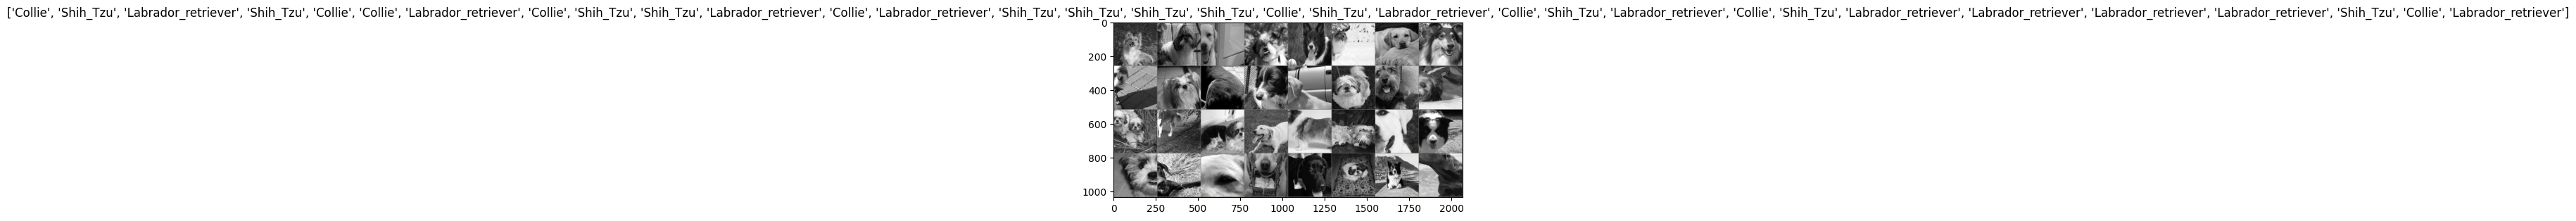

In [9]:
print("\n\n ****** Visualizando una muestra de las imágenes ******")
inputs, classes = next(iter(train_loader)) # Se consigue un lote de las imágenes
out = torchvision.utils.make_grid(inputs) # Se construye un grid para visualizar
imshow(out, title=[clases[x] for x in classes])

### Paso 3: definición de la arquitectura

In [10]:
print("\n\n ****** Defining ResNet model ******")
import torch.nn as nn
import pretrainedmodels as pm
model = pm.__dict__[retrained_model](pretrained='imagenet').to(device)
model.avg_pool = nn.AdaptiveAvgPool2d(1).to(device)
model.last_linear = nn.Sequential(nn.BatchNorm1d(512), #2048
                                  nn.Dropout(p=0.25),
                                  nn.Linear(in_features=512, out_features=256), #2048
                                  nn.ReLU(),
                                  nn.BatchNorm1d(256, eps=1e-05, momentum=0.1), #2048
                                  nn.Dropout(p=0.5),
                                  nn.Linear(in_features=256, out_features=3)).to(device) #2048 #CLASIFICADOR

print("*Total de parámetros")
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")



 ****** Defining ResNet model ******


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.5MB/s]


*Total de parámetros
11,310,147 total parameters.
11,310,147 training parameters.


### Entrenamiento

In [11]:
print("\n\n ****** Training ******")
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
early_stopper = EarlyStopper(patience=patience, min_delta=10)
best_acc = 0.0

for epoch in range(epochs):
    print('-' * 89)
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, exp_lr_scheduler,criterion, device, num_images_train)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader,  criterion, device, num_images_val)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    valid_acc.append(valid_epoch_acc.detach().cpu().numpy())
    print(f"Training loss: {np.mean(train_epoch_loss):.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*89)

    if valid_epoch_acc > best_acc:
        best_acc = valid_epoch_acc

    if early_stopper.early_stop(valid_epoch_loss):
        break
    time.sleep(5)

print(f'Best val Acc: {best_acc:4f}')
save_model(epochs, model, optimizer, criterion)
print('* Training complete')



 ****** Training ******
-----------------------------------------------------------------------------------------
[INFO]: Epoch 1 of 5


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.622, training acc: 0.772
Validation loss: 0.497, validation acc: 0.815
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
[INFO]: Epoch 2 of 5


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.417, training acc: 0.828
Validation loss: 0.348, validation acc: 0.907
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
[INFO]: Epoch 3 of 5


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.453, training acc: 0.832
Validation loss: 0.303, validation acc: 0.907
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
[INFO]: Epoch 4 of 5


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.407, training acc: 0.846
Validation loss: 0.288, validation acc: 0.926
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
[INFO]: Epoch 5 of 5


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.441, training acc: 0.825
Validation loss: 0.305, validation acc: 0.907
-----------------------------------------------------------------------------------------
Best val Acc: 0.925926
* Training complete




 ****** Plotting loss ******


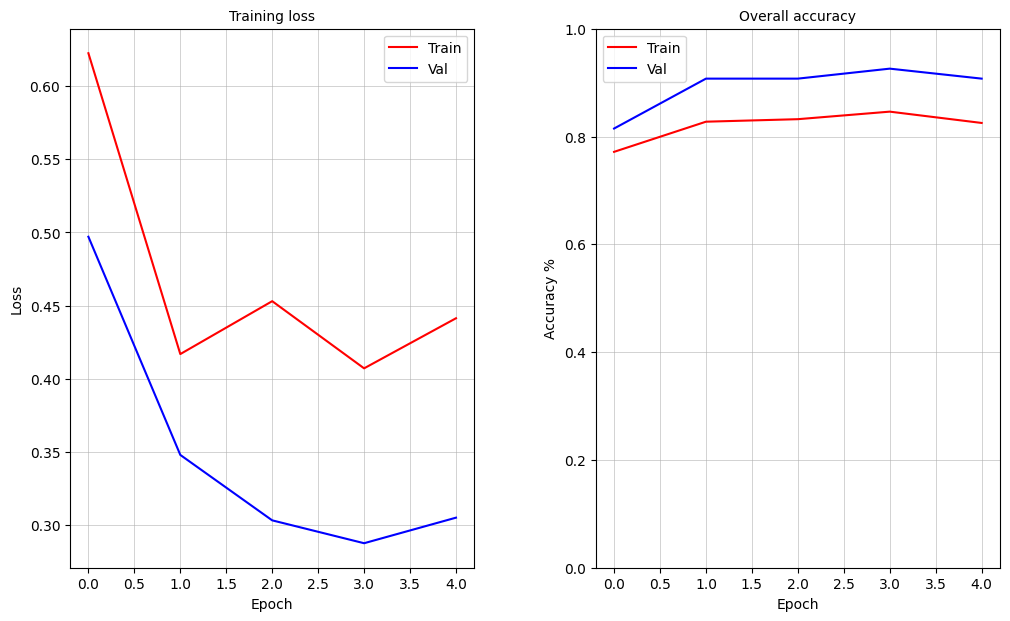

In [12]:
print("\n\n ****** Plotting loss ******")
plotting_loss(train_acc, valid_acc, train_loss, valid_loss, filename)

In [13]:
print("\n\n ****** Inference ******")
y_true, y_pred = inference(model, test_loader)
print("list_ytrue: ", y_true)
print("list_ypred: ", y_pred)



 ****** Inference ******
i :  0
i :  1
list_ytrue:  [1, 2, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 2, 0, 0, 2, 2, 1, 2, 2, 0, 0, 1, 2, 2, 1, 0, 2, 1, 0, 2, 2, 2, 0, 1, 2]
list_ypred:  [1, 2, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 2, 2, 1, 2, 2, 0, 0, 1, 2, 2, 1, 0, 2, 1, 0, 2, 2, 2, 1, 1, 2]




 ****** Compute metrics ******
Predict  0        1        2        
Actual
0        11       4        1        

1        0        18       0        

2        1        1        19       





Overall Statistics : 

95% CI                                                            (0.78,0.96)
ACC Macro                                                         0.92
ARI                                                               0.66
AUNP                                                              0.9
AUNU                                                              0.9
Bangdiwala B                                                      0.79
Bennett S                                                         0.81
CBA                                                               0.79
CSI                                                               0.75
Chi-Squared                                                       72.87
Chi-Squared DF                                                    

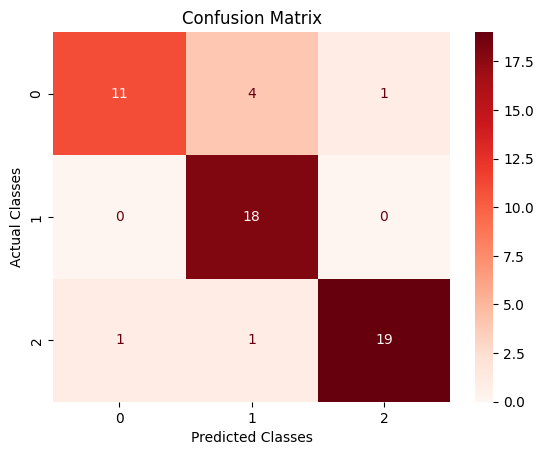

In [14]:
print("\n\n ****** Compute metrics ******")
compute_metrics(y_true, y_pred)